# Loading Widefield Imaging Data

Imaging data recorded using widefield

In [1]:
# Turn off logging and disable tqdm this is a hidden cell on docs page
import logging
import os

logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

os.environ["TQDM_DISABLE"] = "1"

## Relevant ALF objects
* imaging
* imagingLightSource
* widefieldU
* widefieldSVT
* widefieldChannels
* widefieldLandmark


## Widefield pipeline
Widefield data collected in the IBL has been collected and processed following the pipeline described by [Couto et al](10.1038/s41596-021-00527-z). Briefly the raw data (imaging.frames.mov) has undergone motion and baseline correction followed by denoising and decomposition (SVD) resulting in a compressed image stack formed of the spatial components (widefieldU.images.npy) and the temporal components (widefeildlSVT.uncorrected.npy). Haemodynamic correction has also been applied yielding corrected temporal components (widefieldSVT.haemoCorrected.npy).


## More details
* [Description of widefield datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.7f0skb6ow9gw)
* [Description of imaging datasets](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.5d32zs4grdoy)


## Relevant packages
Please install the wfield package to work with widefield data
```python
pip install git+https://github.com/jcouto/wfield.git
```
We encourage you to look at futher examples and tutorials that are available in the [wfield github repo](https://github.com/jcouto/wfield/tree/master).


## Finding sessions with widefield data
Sessions that contain widefield data can be found by searching for sessions with a corresponding widefield dataset

In [2]:
from one.api import ONE
one = ONE()
sessions = one.search(dataset='widefieldU.images.npy')
print(f'{len(sessions)} sessions with widefield data found')

50 sessions with widefield data found


## Loading widefield imaging stack data
The imaging stack can be reconstructed from the decomponsed spatial and temporal components of the SVD. The imaging stack contains the imaging data for each frame in the session and has dimensions (nFrames, nx, ny) where `nx` is the width of the imaging window, and `ny` the height.

In [3]:
import wfield

# Choose the first session
eid = sessions[0]
# Load the spatial components
U = one.load_dataset(eid, 'widefieldU.images.npy')
# Load the haemocorrected temporal components
SVT = one.load_dataset(eid, 'widefieldSVT.haemoCorrected.npy')
# Use wfield package to build imaging stack
stack = wfield.SVDStack(U, SVT)

print(f'Dimensions of imaging stack: {stack.shape}')

Dimensions of imaging stack: [85132, 540, 640]


## Aligning data to the Allen reference atlas
We can register the imaging stack to the Allen reference atlas using the landmark file that contains the bregma and lambda position in the imaging window

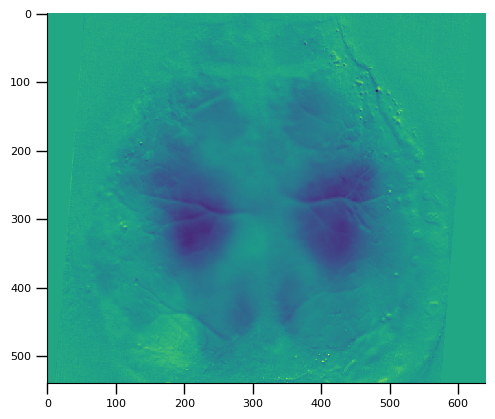

In [4]:
lmark_file = one.load_dataset(eid, 'widefieldLandmarks.dorsalCortex.json', download_only=True)
landmarks = wfield.load_allen_landmarks(lmark_file)
# Warp and register the image stack to the Allen dorsal cortex
stack.set_warped(True, M=landmarks['transform'])

# plot the data from the 100th frame
import matplotlib.pyplot as plt
plt.imshow(stack[100])

## Loading imaging times
Timestamps for each frame are in seconds from session start and are aligned to other times from the session, e.g behavioral or video events. The timestamps contain times for both the functional (haemodynamic corrected) and non-functional channel.

In [5]:
import pandas as pd

times = one.load_dataset(eid, 'imaging.times.npy')
channels = one.load_dataset(eid, 'imaging.imagingLightSource.npy')
channel_info = one.load_dataset(eid, 'imagingLightSource.properties.htsv', download_only=True)
channel_info = pd.read_csv(channel_info)

# If haemocorrected need to take timestamps that correspond to functional channel
functional_channel = 470
functional_chn = channel_info.loc[channel_info['wavelength'] == functional_channel]['channel_id'].values[0]
times = times[channels == functional_chn]